In [1]:
# !git clone https://github.com/WaShindeiru/ResidualAttentionNetwork-pytorch

In [2]:
# !cp -r ResidualAttentionNetwork-pytorch/* .

In [3]:
from ResNet.model.residual_attention_network import ResidualAttentionModel_92_32input_update as ResidualAttentionModel

In [4]:

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform_train = transforms.Compose([
    transforms.Pad(padding=2),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

train_dataset = datasets.FashionMNIST(
    root='./data_mnist_train',
    train=True,
    download=True,
    transform=transform_train
)

test_dataset = datasets.FashionMNIST(
    root='./data_mnist_test',
    train=False,
    download=True,
    transform=transform_train
)

In [5]:
batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [6]:
images, labels = next(iter(train_loader))
# 64, 1, 28, 28
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Images shape: torch.Size([32, 3, 32, 32])
Labels shape: torch.Size([32])


In [7]:
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

In [8]:


data_iter = iter(train_loader)
images, labels = next(data_iter)

In [9]:
def show_images_with_labels(images, labels):
    fig = plt.figure(figsize=(10, 4))
    for idx in range(5):
        print(images[idx].shape)
        ax = fig.add_subplot(1, 5, idx + 1, xticks=[], yticks=[])
        ax.imshow(images[idx][0].squeeze(), cmap='gray')
        ax.set_title(class_names[labels[idx].item()])
    plt.show()

torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


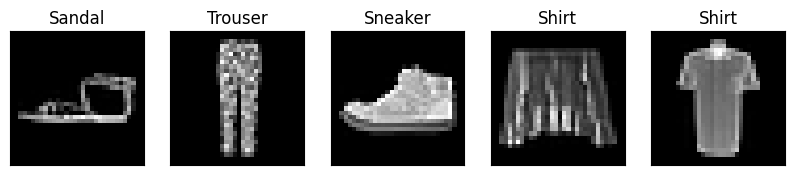

In [10]:
show_images_with_labels(images, labels)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResidualAttentionModel().to(device)
# print(model)

lr = 0.1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=lr
)

total_epochs = 10
best_acc = 0.0
loss_history = [[] for x in range(total_epochs)]
loss_history_test = [[] for x in range(total_epochs)]
history = []
# history = [{} for x in range(total_epochs)]

for epoch in range(total_epochs):
    model.train()
    epoch_start = time.time()
    running_loss = 0.0
    val_loss = 0.0
    total_train = 0
    correct_train = 0

    train_loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{total_epochs}", leave=False)

    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        total_train += images.size(0)
        correct_train += (predicted == labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loss_history[epoch].append(loss.item())
        train_loop.set_postfix(loss=loss.item())

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            test_loss = criterion(outputs, labels)
            loss_history_test[epoch].append(test_loss.item())
            val_loss += test_loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    train_acc = 100 * correct_train / total_train

    epoch_time = time.time() - epoch_start
    history.append(
        {
            'loss': running_loss / len(train_loader),
            'val_loss': val_loss / len(train_loader),
            'train_acc': train_acc,
            'val_acc': val_acc,
            'epoch_time': epoch_time,
        }
    )
    print(
        f"Epoch [{epoch + 1}/{total_epochs}] | "
        f"Loss: {running_loss / len(train_loader):.4f} | "
        f"Val Acc: {val_acc:.2f}% | "
        f"Time: {epoch_time:.2f}s"
    )

Epoch [1/10] | Loss: 0.4629 | Val Acc: 88.98% | Time: 153.97s


Epoch [2/10] | Loss: 0.2563 | Val Acc: 91.17% | Time: 143.95s


Epoch [3/10] | Loss: 0.2054 | Val Acc: 91.42% | Time: 136.03s


Epoch [4/10] | Loss: 0.1752 | Val Acc: 92.39% | Time: 132.72s


Epoch [5/10] | Loss: 0.1529 | Val Acc: 92.80% | Time: 136.88s


Epoch [6/10] | Loss: 0.1274 | Val Acc: 92.83% | Time: 137.88s


Epoch [7/10] | Loss: 0.1081 | Val Acc: 92.78% | Time: 138.28s


Epoch [8/10] | Loss: 0.0913 | Val Acc: 92.70% | Time: 137.78s


Epoch [9/10] | Loss: 0.0764 | Val Acc: 92.72% | Time: 137.82s


Epoch [10/10] | Loss: 0.0636 | Val Acc: 91.60% | Time: 132.10s


In [12]:
import matplotlib.pyplot as plt

dict_keys(['loss', 'val_loss', 'train_acc', 'val_acc', 'epoch_time'])


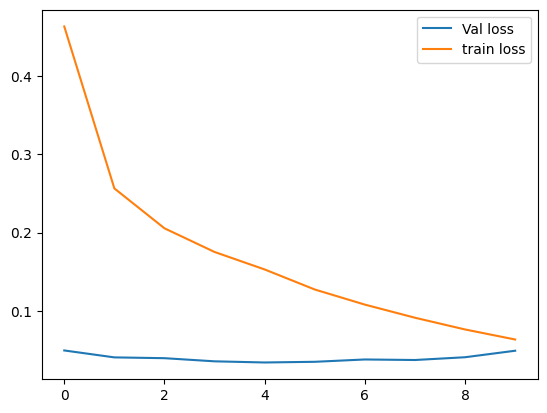

In [13]:
print(history[0].keys())
val_loss_ = [history[x]['val_loss'] for x in range(10)]
train_loss_ = [history[x]['loss'] for x in range(10)]

plt.figure()
plt.plot(val_loss_, label='Val loss')
plt.plot(train_loss_, label='train loss')
plt.legend()

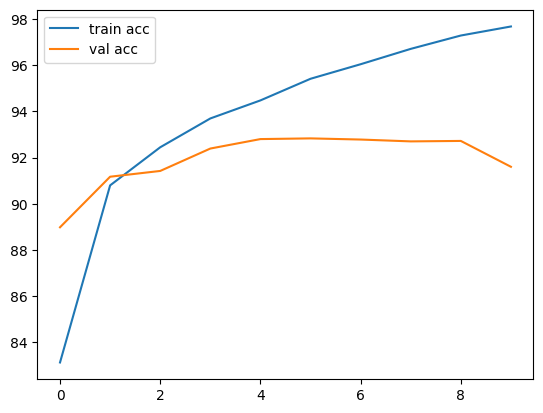

In [14]:
train_acc_ = [history[x]['train_acc'] for x in range(10)]
val_acc_ = [history[x]['val_acc'] for x in range(10)]

plt.figure()
plt.plot(train_acc_, label='train acc')
plt.plot(val_acc_, label='val acc')
plt.legend()


In [15]:
from datetime import datetime

now = datetime.now()
timestamp = now.strftime("%Y-%m-%d_%H:%M:%S")

In [16]:
name = "ResidualAttentionModel_92_32input_update_"+timestamp+".pth"
path = "./weights/" + name
torch.save(model.state_dict(), path)

In [17]:
from pathlib import Path
path = "./results/ResidualAttentionModel_92_32input_update_"+timestamp
Path(path).mkdir(parents=True, exist_ok=True)

In [18]:
import pickle

with open(path + "/history.pickle", 'wb') as f:
    pickle.dump(history, f)

with open(path + "/loss_history.pickle", 'wb') as f:
    pickle.dump(loss_history, f)

with open(path + "/loss_history_test.pickle", 'wb') as f:
    pickle.dump(loss_history_test, f)

In [19]:
test_iter = iter(test_loader)

In [20]:
img, label = next(test_iter)
img, label = img.to(device), label.to(device)

result = model(img)

In [21]:
_, predicted = torch.max(result.data, 1)
print(predicted)

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 6, 4, 8, 0, 4, 5, 7, 5,
        1, 6, 6, 0, 9, 3, 8, 8], device='cuda:0')


torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


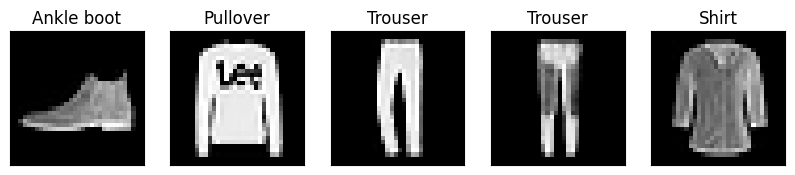

In [22]:
show_images_with_labels(img.to('cpu'), label.to('cpu'))

In [23]:
def show_images_with_labels_predicted(images, labels, result):
    fig = plt.figure(figsize=(18, 6))
    _, predicted = torch.max(result.data, 1)
    for idx in range(5):
        print(images[idx].shape)
        ax = fig.add_subplot(1, 5, idx + 1, xticks=[], yticks=[])
        ax.imshow(images[idx][0].squeeze(), cmap='gray')
        ax.set_title(f"T: {class_names[labels[idx].item()]}, P: {class_names[predicted[idx].item()]}")
    plt.show()

torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


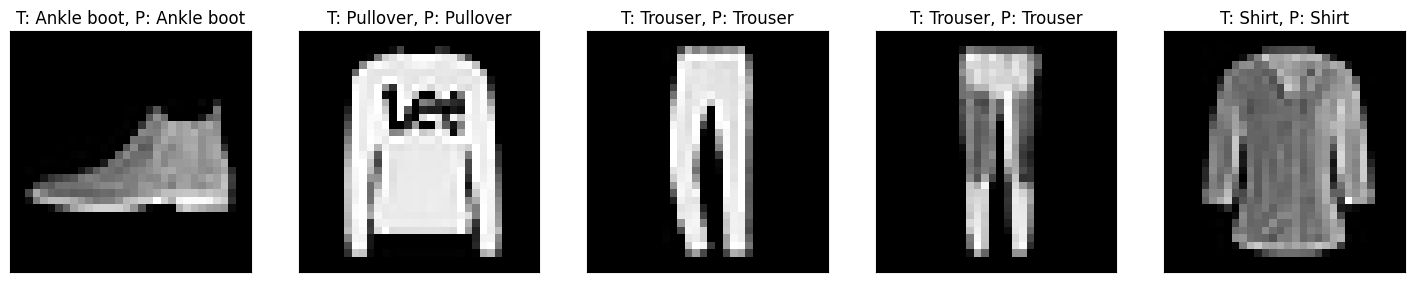

In [24]:
show_images_with_labels_predicted(img.to('cpu'), label.to('cpu'), result.to('cpu'))

In [25]:
# from __future__ import print_function, division
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.autograd import Variable
# from torch.utils.data_mnist import Dataset, DataLoader
# import numpy as np
# import torchvision
# from torchvision import transforms, datasets, models
# import os
# import cv2
# import time
# # from model.residual_attention_network_pre import ResidualAttentionModel
# # based https://github.com/liudaizong/Residual-Attention-Network
# from temp.model.residual_attention_network import ResidualAttentionModel_92_32input_update as ResidualAttentionModel
#
# model_file = './temp/model_92_sgd.pkl'
#
#
# # for test
# def test(model, test_loader, btrain=False, model_file='./temp/model_92_sgd.pkl'):
#     # Test
#     if not btrain:
#         model.load_state_dict(torch.load(model_file))
#     model.eval()
#
#     correct = 0
#     total = 0
#     #
#     class_correct = list(0. for i in range(10))
#     class_total = list(0. for i in range(10))
#
#     for images, labels in test_loader:
#         images = Variable(images.cuda())
#         labels = Variable(labels.cuda())
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data_mnist, 1)
#         total += labels.size(0)
#         correct += (predicted == labels.data_mnist).sum()
#         #
#         c = (predicted == labels.data_mnist).squeeze()
#         for i in range(20):
#             label = labels.data_mnist[i]
#             class_correct[label] += c[i]
#             class_total[label] += 1
#
#     print('Accuracy of the model on the test images: %d %%' % (100 * float(correct) / total))
#     print('Accuracy of the model on the test images:', float(correct)/total)
#     for i in range(10):
#         print('Accuracy of %5s : %2d %%' % (
#             classes[i], 100 * class_correct[i] / class_total[i]))
#     return correct / total
#
#
# # Image Preprocessing
# transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomCrop((32, 32), padding=4),   #left, top, right, bottom
#     # transforms.Scale(224),
#     transforms.ToTensor()
# ])
# test_transform = transforms.Compose([
#     transforms.ToTensor()
# ])
# # when image is rgb, totensor do the division 255
# # CIFAR-10 Dataset
# train_dataset = datasets.CIFAR10(root='./data_mnist/',
#                                train=True,
#                                transform=transform,
#                                download=True)
#
# test_dataset = datasets.CIFAR10(root='./data_mnist/',
#                               train=False,
#                               transform=test_transform)
#
# # Data Loader (Input Pipeline)
# train_loader = torch.utils.data_mnist.DataLoader(dataset=train_dataset,
#                                            batch_size=64, # 64
#                                            shuffle=True, num_workers=8)
# test_loader = torch.utils.data_mnist.DataLoader(dataset=test_dataset,
#                                           batch_size=20,
#                                           shuffle=False)
#
# images, labels = next(iter(train_loader))
# # 64, 1, 28, 28
# print(f"Images shape: {images.shape}")
# print(f"Labels shape: {labels.shape}")
#
# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# model = ResidualAttentionModel().cuda()
# print(model)
#
# test(model, test_loader, btrain=False)
#
